In [ ]:
import os 
os.chdir("/home/canyon/Bus-Weather-Impacts")
from src.utils import *
import pandas as pd
import os
import osmnx as ox
import geopandas as gpd
import networkx as nx
from sklearn.neighbors import KDTree
import numpy as np

: 

In [4]:
buses = read_parquet_from_tar_gz("https://urbantech-public.s3.amazonaws.com/DO-NOT-DELETE-BUSOBSERVATORY-PUBLIC-DATASET/one-system-day.tar.gz")

In [5]:
place = "New York City, New York, USA"
G = ox.graph_from_place(place, network_type='drive')

# Convert graph nodes to a DataFrame for KDTree
nodes = ox.graph_to_gdfs(G, edges=False).reset_index()
tree = KDTree(nodes[['y', 'x']], metric='euclidean')

In [6]:
# Query the KDTree for nearest node to each point
nearest_nodes = tree.query(np.array(buses[['lat', 'lon']]), k=1, return_distance=False)
buses['nearest_node'] = nearest_nodes.flatten()

# Map node IDs to OSM IDs
buses['nearest_osm_id'] = buses['nearest_node'].map(nodes['osmid'])
buses = buses.merge(nodes, left_on = "nearest_osm_id", right_on = "osmid")
buses = gpd.GeoDataFrame(buses, geometry='geometry')

In [7]:
buses["time_diff"] = buses.groupby("trip_id")["timestamp"].diff().dt.total_seconds()
buses = buses.query("time_diff >= 60")

In [8]:
buses_with_nodes = buses.sort_values(["trip_id", "timestamp"]).drop_duplicates(subset = ["trip_id", "nearest_osm_id"],  keep = "first").to_crs(2263)
buses_with_nodes = buses_with_nodes[["route", "timestamp", "trip_id", "osmid", "vehicle_id",  "geometry"]]

In [9]:
buses_with_nodes["prev_osmid"] = buses_with_nodes.groupby("trip_id")["osmid"].shift()

In [ ]:
nodes_coords = nodes.to_crs(2263)

In [10]:
def compute_distance(row, graph):
    try:
        return nx.shortest_path_length(graph, row['prev_osmid'], row['osmid'], weight='length')
    except nx.NetworkXNoPath:
        return float('nan')

#unqiue_node_pairs = buses_with_nodes[["osmid", "prev_osmid"]].dropna().drop_duplicates().astype(int)
#unqiue_node_pairs["distance_meters_osm"] = unqiue_node_pairs.apply(compute_distance, graph=G, axis=1)
#unqiue_node_pairs.to_parquet("node_pairs.parquet")

unique_node_pairs = pd.read_parquet("node_pairs.parquet")
buses_with_nodes = buses_with_nodes.merge(unique_node_pairs, how = "left")
buses_with_nodes["osmid"] = buses_with_nodes["osmid"].astype(str)
buses_with_nodes["prev_osmid"] = buses_with_nodes["prev_osmid"].astype("Int64").astype(str)

In [11]:
buses_with_nodes["time_diff_seconds"] = buses_with_nodes.groupby("trip_id")["timestamp"].diff().dt.total_seconds()
buses_with_nodes["speed_mph_osm"] =  (buses_with_nodes["distance_meters_osm"] / 1609) / (buses_with_nodes["time_diff_seconds"] / 3600)

In [13]:
nodes.query("osmid == 42949762 | osmid == 598367717")

,osmid,y,x,ref,highway,street_count,geometry
34181,42949762,40.602807,-74.057823,NaN,stop,5,POINT (-74.05782 40.60281)
44236,598367717,40.601604,-74.062715,NaN,NaN,3,POINT (-74.06272 40.60160)


In [12]:
buses_with_nodes.query("speed_mph_osm > 100")

,route,timestamp,trip_id,osmid,vehicle_id,geometry,prev_osmid,distance_meters_osm,time_diff_seconds,speed_mph_osm
275,S53,2023-07-05 00:29:00,MTA NYCT_CA_C3-Saturday-144000_MISC_373,42949762,MTA NYCT_8234,POINT (968193.418 158900.396),598367717,8702.895,185.0,105.253967
324,SIM33C,2023-07-05 00:55:31,MTA NYCT_CA_C3-Saturday-145000_MISC_383,42465868,MTA NYCT_2716,POINT (984524.411 180790.815),449388060,3676.624,30.0,274.204400
398,SIM3C,2023-07-05 01:02:59,MTA NYCT_CA_C3-Saturday-146500_MISC_387,448100066,MTA NYCT_2672,POINT (973470.991 162852.061),598365339,9693.774,61.0,355.557228
399,SIM3C,2023-07-05 01:04:01,MTA NYCT_CA_C3-Saturday-146500_MISC_387,42949762,MTA NYCT_2672,POINT (968193.418 158900.396),448100066,11903.144,62.0,429.552702
472,S40,2023-07-05 01:08:48,MTA NYCT_CA_C3-Saturday-147000_MISC_389,42944230,MTA NYCT_7031,POINT (935000.715 164643.170),1934649808,2968.265,62.0,107.116763
...,...,...,...,...,...,...,...,...,...,...
787881,S61,2023-07-05 23:30:45,MTA NYCT_YU_C3-Weekday-SDon-139500_S6191_470,42974867,MTA NYCT_8273,POINT (956113.039 164455.468),43013987,4354.697,8.0,1217.907800
787892,S61,2023-07-05 23:40:56,MTA NYCT_YU_C3-Weekday-SDon-139500_S6191_470,4517182496,MTA NYCT_8273,POINT (963207.839 171904.571),42964909,3403.731,10.0,761.555724
787917,SIM1C,2023-07-05 23:53:33,MTA NYCT_YU_C3-Weekday-SDon-139800_SIM1_570,5487759985,MTA NYCT_2560,POINT (982755.693 189136.644),607911351,5891.931,61.0,216.109707
787922,SIM1C,2023-07-05 23:59:39,MTA NYCT_YU_C3-Weekday-SDon-139800_SIM1_570,5882645228,MTA NYCT_2560,POINT (979506.853 168674.767),598322078,4215.700,61.0,154.627352


In [ ]:
buses_with_nodes['distance_diff_feet'] = buses_with_nodes.groupby('trip_id').apply(calculate_distances).reset_index(level=0, drop=True)

In [ ]:
buses.query("route == 'M96'").plot()

In [ ]:
data.head(50)

In [ ]:
plot_osm_path(start, end)

<Axes: >

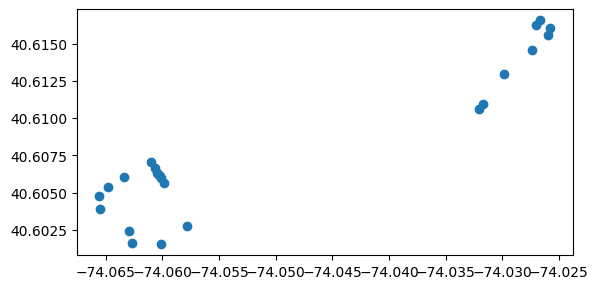

In [18]:
path_nodes = nx.shortest_path(G, 598367717, 42949762)


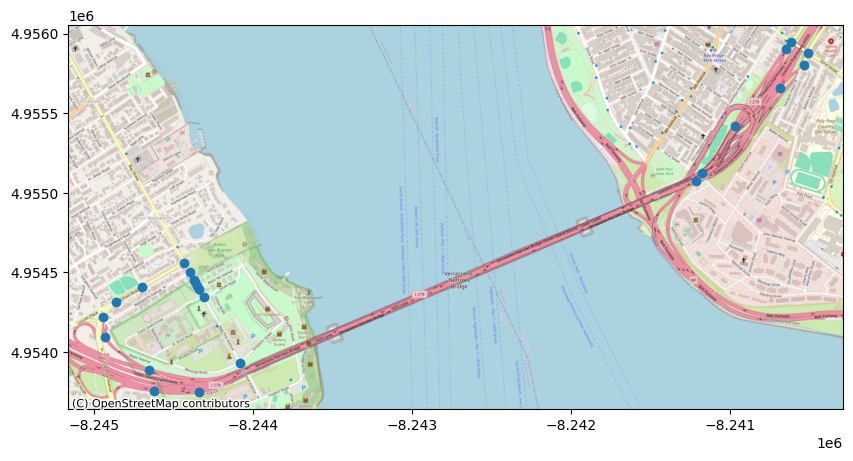

In [30]:
import contextily as ctx
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
nodes.query("osmid.isin(@path_nodes)").to_crs(3857).plot(ax = ax)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()


UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f3fa0f86680>

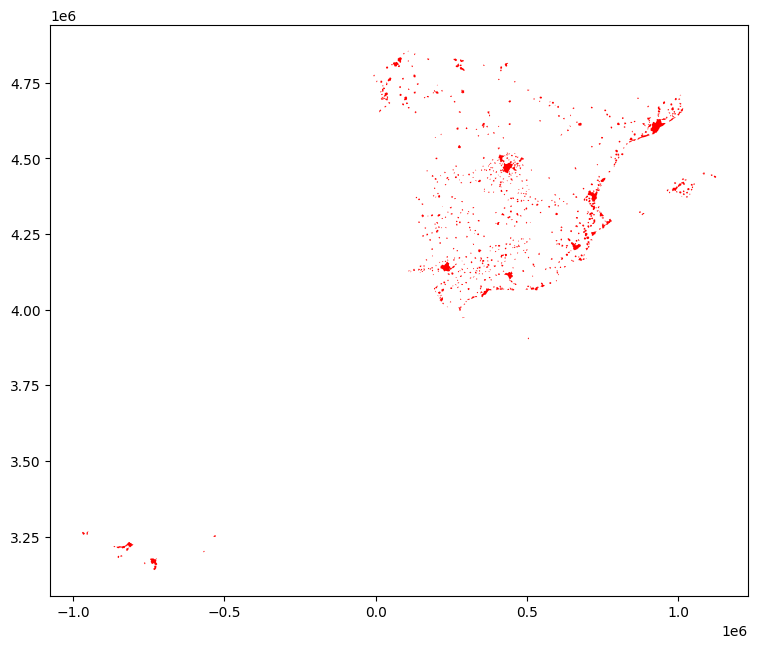

In [28]:
data_url = "https://ndownloader.figshare.com/files/20232174"
db = gpd.read_file(data_url)
ax = db.plot(color="red", figsize=(9, 9))
ctx.add_basemap(ax, crs=db.crs.to_string())
